This project involves building a fraud detection system using financial transaction data. The primary goal is to develop a machine learning model capable of identifying fraudulent transactions with high accuracy and recall. The process includes data preprocessing, feature engineering, and model training using Random Forest.

In [4]:
import pandas as pd

In [6]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df.describe

<bound method NDFrame.describe of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   

Checking for missing values.

In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In this dataset, there are no missing values, so no imputation or deletion was required.

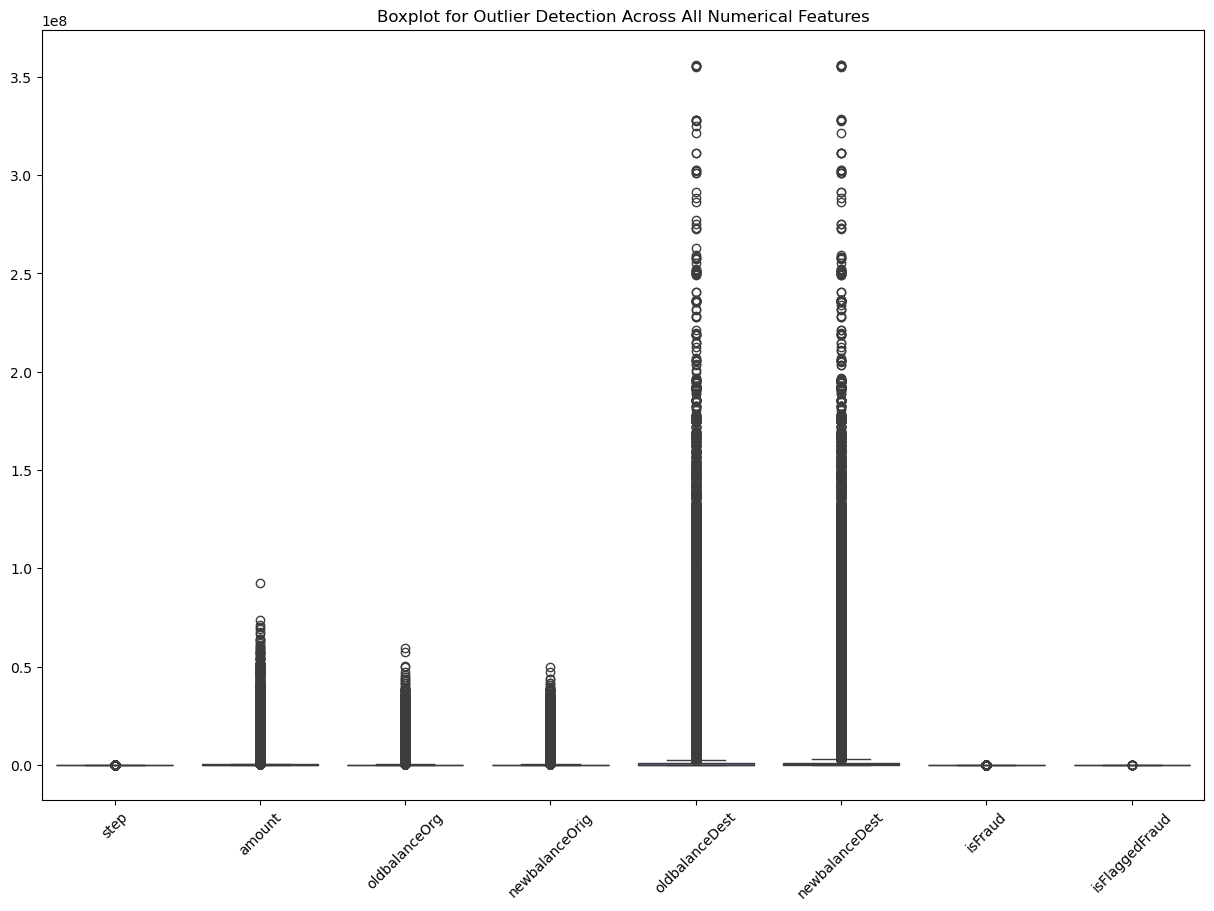

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot boxplots for all numerical features
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[numerical_columns])
plt.xticks(rotation=45)  # Rotate column labels for better visibility
plt.title("Boxplot for Outlier Detection Across All Numerical Features")
plt.show()

Outliers can be handled using the IQR (Interquartile Range) method to cap extreme values.

Columns like amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest were capped to remove values beyond 1.5 times the IQR.
Capping outliers ensured that the model remained stable and was not skewed by extreme transactions.


Lower Bound=Q1−1.5×IQR, Upper Bound=Q3+1.5×IQR

In [13]:
mod_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                     'oldbalanceDest', 'newbalanceDest']
for col in mod_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
    print("Number of outliers in " ,col," : ", outliers.shape[0])

Number of outliers in  amount  :  338078
Number of outliers in  oldbalanceOrg  :  1112507
Number of outliers in  newbalanceOrig  :  1053391
Number of outliers in  oldbalanceDest  :  786135
Number of outliers in  newbalanceDest  :  738527


In [14]:
# Cap outliers for all numerical columns
for col in mod_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[f'{col}_capped'] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Summary after capping
print(df[[col for col in df.columns if '_capped' in col]].describe())

       amount_capped  oldbalanceOrg_capped  newbalanceOrig_capped  \
count   6.362620e+06          6.362620e+06           6.362620e+06   
mean    1.322667e+05          7.221247e+04           8.872275e+04   
std     1.462368e+05          1.024141e+05           1.393412e+05   
min     0.000000e+00          0.000000e+00           0.000000e+00   
25%     1.338957e+04          0.000000e+00           0.000000e+00   
50%     7.487194e+04          1.420800e+04           0.000000e+00   
75%     2.087215e+05          1.073152e+05           1.442584e+05   
max     5.017193e+05          2.682879e+05           3.606460e+05   

       oldbalanceDest_capped  newbalanceDest_capped  
count           6.362620e+06           6.362620e+06  
mean            6.003940e+05           7.150404e+05  
std             8.369711e+05           9.673665e+05  
min             0.000000e+00           0.000000e+00  
25%             0.000000e+00           0.000000e+00  
50%             1.327057e+05           2.146614e+05  


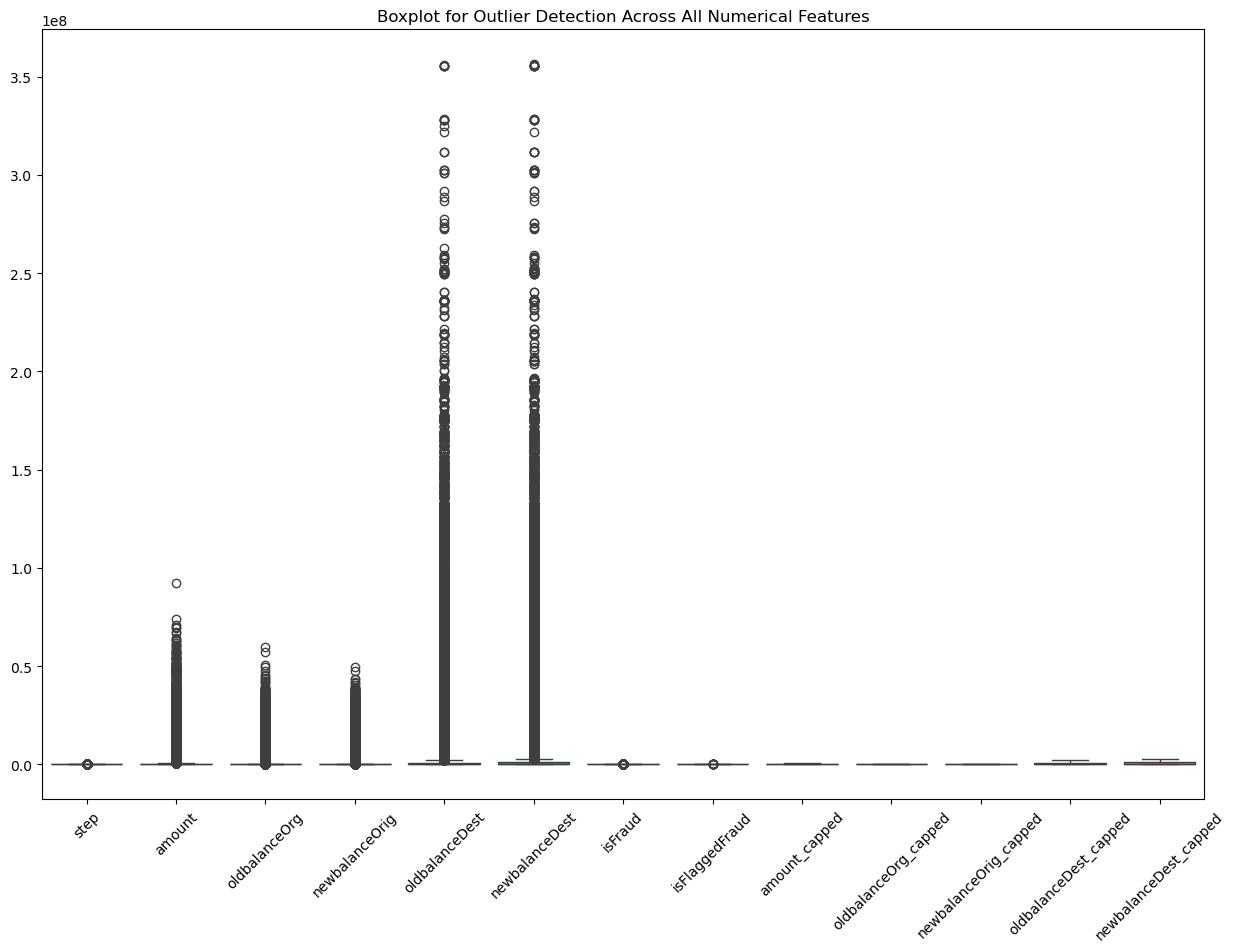

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot boxplots for all numerical features
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[numerical_columns])
plt.xticks(rotation=45)  # Rotate column labels for better visibility
plt.title("Boxplot for Outlier Detection Across All Numerical Features")
plt.show()

In [16]:
print(df[[col for col in df.columns if '_capped' in col]].describe())

       amount_capped  oldbalanceOrg_capped  newbalanceOrig_capped  \
count   6.362620e+06          6.362620e+06           6.362620e+06   
mean    1.322667e+05          7.221247e+04           8.872275e+04   
std     1.462368e+05          1.024141e+05           1.393412e+05   
min     0.000000e+00          0.000000e+00           0.000000e+00   
25%     1.338957e+04          0.000000e+00           0.000000e+00   
50%     7.487194e+04          1.420800e+04           0.000000e+00   
75%     2.087215e+05          1.073152e+05           1.442584e+05   
max     5.017193e+05          2.682879e+05           3.606460e+05   

       oldbalanceDest_capped  newbalanceDest_capped  
count           6.362620e+06           6.362620e+06  
mean            6.003940e+05           7.150404e+05  
std             8.369711e+05           9.673665e+05  
min             0.000000e+00           0.000000e+00  
25%             0.000000e+00           0.000000e+00  
50%             1.327057e+05           2.146614e+05  


In [17]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'amount_capped', 'oldbalanceOrg_capped',
       'newbalanceOrig_capped', 'oldbalanceDest_capped',
       'newbalanceDest_capped'],
      dtype='object')

Creating a new dataset using the 'capped'columns. Hence, dropping the corresponding columns

In [19]:
# List the columns you want to drop
cols_to_drop = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Create a new DataFrame with the columns dropped
df_new = df.drop(columns=cols_to_drop)

# Check the new DataFrame's structure
df_new.head()


,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,amount_capped,oldbalanceOrg_capped,newbalanceOrig_capped,oldbalanceDest_capped,newbalanceDest_capped
0,1,PAYMENT,C1231006815,M1979787155,0,0,9839.64,170136.0,160296.36,0.0,0.0
1,1,PAYMENT,C1666544295,M2044282225,0,0,1864.28,21249.0,19384.72,0.0,0.0
2,1,TRANSFER,C1305486145,C553264065,1,0,181.00,181.0,0.00,0.0,0.0
3,1,CASH_OUT,C840083671,C38997010,1,0,181.00,181.0,0.00,21182.0,0.0
4,1,PAYMENT,C2048537720,M1230701703,0,0,11668.14,41554.0,29885.86,0.0,0.0


As the columns "nameOrig" and "nameDest" have no influence on the data being fraud, these columns will be dropped.

In [21]:
df_new.drop(columns=['nameOrig', 'nameDest'], inplace=True)
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()

# Apply label encoding to the 'type' column
df_new['type'] = le.fit_transform(df_new['type'])

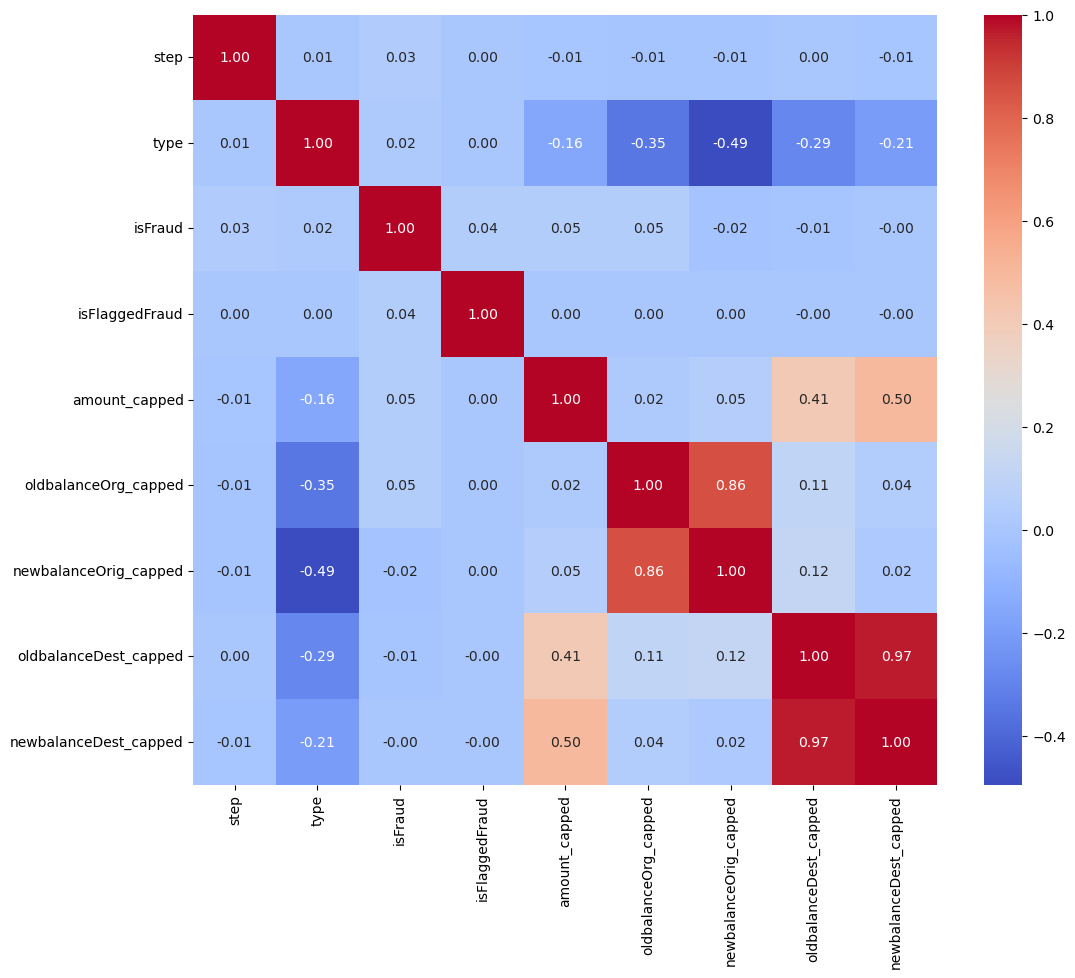

In [22]:
correlation_matrix = df_new.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

As the columns "oldbalanceOrg_capped" and "newbalanceOrig_capped" have a high correlation value, we will combine these columns into one by taking avaerage of both. Similary "oldbalanceDest_capped" and "newbalanceDest_capped" is handled.

In [24]:
df_new.columns

Index(['step', 'type', 'isFraud', 'isFlaggedFraud', 'amount_capped',
       'oldbalanceOrg_capped', 'newbalanceOrig_capped',
       'oldbalanceDest_capped', 'newbalanceDest_capped'],
      dtype='object')

In [25]:
df_new['combined_balance'] = df_new[['oldbalanceOrg_capped', 'newbalanceOrig_capped']].mean(axis=1)
df_new['combined_dest'] = df_new[['oldbalanceDest_capped','newbalanceDest_capped']].mean(axis=1)
df_new.drop(columns=['oldbalanceOrg_capped', 'newbalanceOrig_capped','oldbalanceDest_capped','newbalanceDest_capped'], inplace=True)

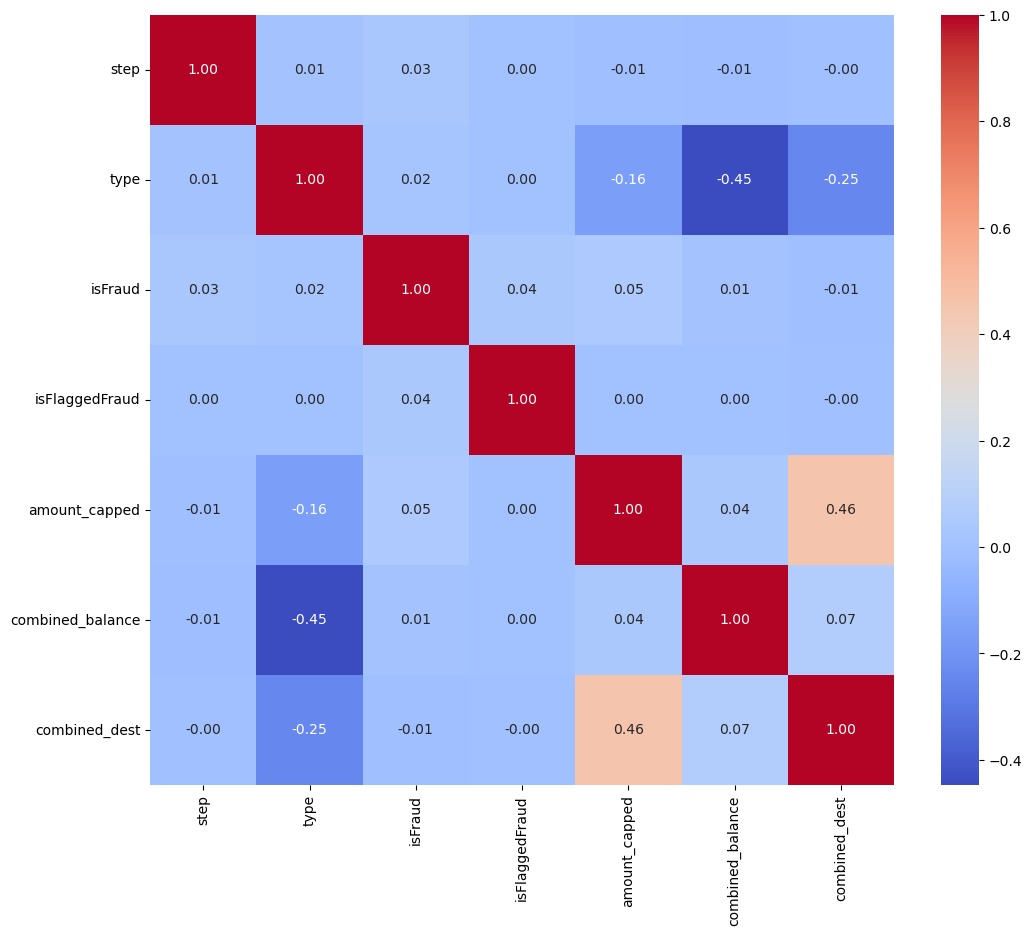

In [26]:
correlation_matrix = df_new.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [27]:
df_new.columns

Index(['step', 'type', 'isFraud', 'isFlaggedFraud', 'amount_capped',
       'combined_balance', 'combined_dest'],
      dtype='object')

The fraud detection model uses a Random Forest Classifier due to its ability to handle complex datasets and imbalanced classes. Key details include:

Data Preprocessing:

Outlier handling using IQR-based capping.
Class imbalance addressed through under-sampling to create a 50-50 balance of fraud and non-fraud cases.
Model Training:

The data was split into 70% training and 30% testing using train_test_split.
The Random Forest algorithm was chosen because it is robust to noise, reduces overfitting through ensemble learning, and handles feature importance well.

The variables were selected based on the following criteria:

Domain Understanding:
Features like amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest are critical for identifying unusual transaction patterns.

Feature Correlation:
Redundant variables (highly correlated features) were combined using feature engineering to reduce noise.
Handling Categorical Data:
The type column (categorical) was encoded into numerical format using one-hot encoding or label encoding.

Feature Importance:
After training the Random Forest model, feature importance was used to determine which variables had the most impact on predictions.

In [29]:
from sklearn.model_selection import train_test_split

X = df_new.drop('isFraud', axis=1)  # Features
y = df_new['isFraud']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
y_pred = model.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))

Accuracy: 0.999607080102222
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.95      0.73      0.83      2435

    accuracy                           1.00   1908786
   macro avg       0.97      0.87      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



Even though the accuracy is high, the recall is just 73%; for a fraud detection model, it is not good enough.

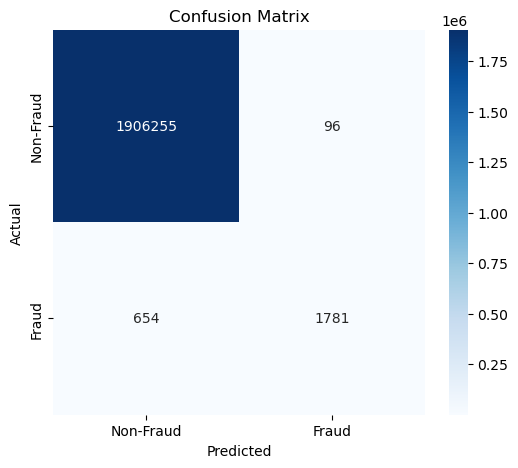

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

It is clear that most of the data point to non-fraud emails, which disbalances the dataset and hence, even though the model has high accuracy it still does not have a good recall.

Adjusting the threshold is especially useful when:

->we are dealing with imbalanced data (fraud cases are rare).

-> Recall (catching fraud cases) is more important than precision (avoiding false alarms).

-> Lowering the threshold makes the model more cautious and increases its ability to detect rare events like fraud.

The idea behind this approach is to adjust how the model makes decisions based on the probabilities of fraud. Typically, machine learning classifiers predict classes using a default threshold of 0.5, meaning any probability above or equal to 50% is classified as positive (fraudulent). However, in cases like fraud detection, where recall (identifying as many fraudulent cases as possible) is critical, this default threshold may not be sufficient.

By lowering the decision threshold (e.g., to 0.2), the model becomes more sensitive to identifying fraud. This means transactions with even a small probability of being fraudulent will be flagged as fraud. As a result:

The recall increases, meaning more fraudulent transactions are correctly identified.
However, this comes at the cost of precision, as the number of false positives (legitimate transactions flagged as fraud) may increase.
This method is particularly useful in imbalanced datasets, like fraud detection, where the minority class (fraud cases) is rare and missing them is costly. Adjusting the threshold allows the model to prioritize catching frauds over avoiding false alarms.


In [37]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get probabilities for the positive class (fraud)
y_prob = rf.predict_proba(X_test)[:, 1]

# Set new threshold for classification
new_threshold = 0.2  # Lower threshold for higher recall
y_pred = (y_prob >= new_threshold).astype(int)

In [38]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))

Accuracy: 0.9995101598607702
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.80      0.82      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.90      0.91      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



Even though the this approach improves recall significantly by adjusting the decision threshold, the dataset remains imbalanced. In real-world fraud detection, class imbalance is common, where legitimate transactions far outnumber fraudulent ones. Training on an imbalanced dataset can cause the model to prioritize the majority class (non-fraud), leading to high accuracy but poor performance in identifying the minority class (fraud).

The improved recall in threshold adjustment occurs because the model becomes more sensitive to detecting fraud by classifying more transactions as fraudulent. However, this comes at a cost:

A higher number of false positives (legitimate transactions misclassified as fraud).
Potential over-dependence on adjusting the threshold, which may not generalize well to new, unseen data.
To address these issues, the first approach balances the dataset by sampling equal proportions of fraudulent and non-fraudulent transactions. This ensures the model has equal exposure to both classes, improving its ability to learn patterns for fraud detection without relying solely on threshold manipulation. As a result:

The model becomes inherently better at detecting fraud during training.
It achieves high recall and precision without artificially lowering the threshold.
Balancing the dataset creates a more robust model that generalizes better and reduces bias toward the majority class. While adjusting the threshold can fine-tune the results, combining both techniques—balancing the dataset and threshold adjustment—often yields the most reliable and consistent performance.

In [42]:
fraud = df_new[df_new['isFraud'] == 1]
non_fraud = df_new[df_new['isFraud'] == 0]
if(len(non_fraud)>len(fraud)):
    n_fraud = len(fraud)
    n_non_fraud = n_fraud  # Match the number of fraud cases for 50-50 balance
    non_fraud_sample = non_fraud.sample(n=n_non_fraud, random_state=42)
    balanced_df = pd.concat([fraud, non_fraud_sample])
else:
    n_non_fraud = len(non_fraud)
    n_fraud = n_non_fraud
    fraud_sample = fraud.sample(n=n_fraud,random_state=42)
    balanced_df = pd.concat([fraud,fraud_sample])

# Shuffle the data to mix fraud and non-fraud cases
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the class distribution
print(balanced_df['isFraud'].value_counts(normalize=True))
balanced_df.info()

isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16426 entries, 0 to 16425
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   step              16426 non-null  int64  
 1   type              16426 non-null  int32  
 2   isFraud           16426 non-null  int64  
 3   isFlaggedFraud    16426 non-null  int64  
 4   amount_capped     16426 non-null  float64
 5   combined_balance  16426 non-null  float64
 6   combined_dest     16426 non-null  float64
dtypes: float64(3), int32(1), int64(3)
memory usage: 834.3 KB


In [43]:
X = balanced_df.drop('isFraud', axis=1)
y = balanced_df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [46]:
y_pred = model.predict(X_test)

In [47]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))

Accuracy: 0.9878271454656117
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1622
           1       0.98      0.99      0.99      1664

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



The confusion matrix clearly shows how the dataset is balanced now. Hence the recall is also high. Balancing the dataset gives the model a fair representation of both classes during training, reducing its bias toward the majority class.

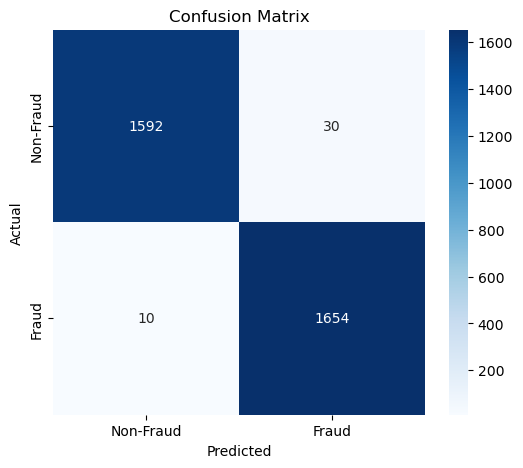

In [49]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

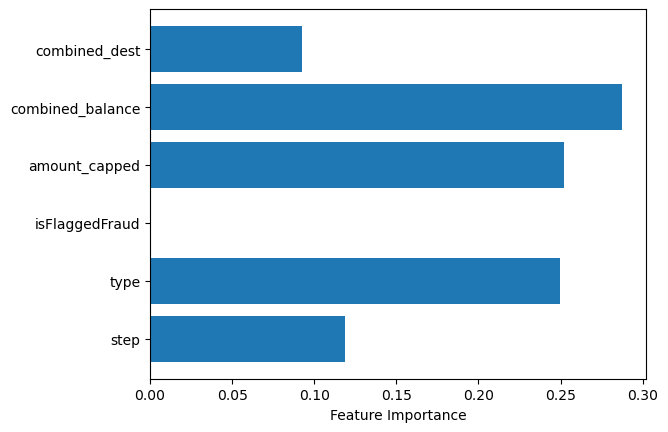

In [79]:
import matplotlib.pyplot as plt
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.show()

The key features identified by the model as predictors of fraud are:

1. Transaction Amount (amount): Higher transaction amounts often indicate fraudulent activity.
2. Origin Account Balances (combined_balance):A sudden drop in the origin account balance suggests a suspicious transaction.
3. Destination Account Balances (combined_dest):Unusual updates to the destination account balance may indicate fraudulent transfers.
4. Transaction Type (type):Specific transaction types like TRANSFER and CASH_OUT were more likely to be fraudulent compared to others.

These factors make logical sense for fraud detection:

->Amount: Fraudsters often target large transactions to maximize their gains.

->Account Balances: Sudden or unusual changes in account balances are typical indicators of fraudulent activity.

->Transaction Type: Fraudulent transactions often involve TRANSFER and CASH_OUT operations where money is moved between accounts or withdrawn.

To improve fraud prevention during infrastructure updates, the following actions should be taken:

1. Real-time Fraud Detection: Deploy real-time monitoring systems to flag suspicious transactions immediately.

2. Enhanced Security Protocols:

    ->Implement multi-factor authentication (MFA) for transactions.
    ->Encrypt sensitive data to prevent unauthorized access.
3. Machine Learning Integration: Continuously train and update the fraud detection model with new data to adapt to evolving fraud patterns.

4. Transaction Limits: Introduce limits on daily transaction amounts and flag large transfers for additional verification.

5. Audit and Logging: Maintain comprehensive logs of transactions and account activities for future analysis.

6. Customer Alerts: Notify customers immediately about high-value or unusual transactions for verification.

To determine the effectiveness of the implemented actions, the following steps can be taken:

1. Monitor Fraud Detection Rates: Compare the number of fraudulent transactions detected before and after implementing the measures.

2. Evaluate Model Metrics: Track metrics like recall, precision, and F1-score over time to ensure the model continues to perform well.

3. Track False Positives: Measure the reduction in false positives to ensure customers are not unnecessarily inconvenienced.

4. Customer Feedback: Collect feedback from customers regarding transaction verification processes and fraud alerts.

5. Perform Regular Audits: Conduct periodic audits of the fraud detection system to identify weaknesses or new fraud patterns.

6. Compare Financial Losses: Measure any decrease in financial losses due to fraud after implementing the new measures.

By tracking these key performance indicators, the company can ensure its infrastructure updates effectively reduce fraud and improve customer trust.

